In [41]:
import string
import numpy as np
from PIL import Image
import os
import tensorflow as tf
tf.get_logger().setLevel("ERROR")
from pickle import dump, load
import matplotlib.pyplot as plt
import cv2
import io
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, LSTM, concatenate
from tensorflow.keras.models import load_model, Model
from tqdm.notebook import tqdm
tqdm().pandas()

0it [00:00, ?it/s]

In [43]:
os.listdir('Flickr8k_text')

['CrowdFlowerAnnotations.txt',
 'ExpertAnnotations.txt',
 'Flickr8k.lemma.token.txt',
 'Flickr8k.token.txt',
 'Flickr_8k.devImages.txt',
 'Flickr_8k.testImages.txt',
 'Flickr_8k.trainImages.txt',
 '__MACOSX']

In [44]:
dataset_images_path = 'Flicker8k_Dataset'
dataset_text_path = 'Flickr8k_text'

In [45]:
def load_txt(path):
    file = open(path, 'r')
    content = file.read()
    file.close()
    return content

In [46]:
def make_dic(path):
    content = load_txt(path)
    lines = content.split('\n')
    dic = {}
    for line in lines[:-1]:
        img_name, caption = line.split('\t')
        img_name = img_name[:-2]
        if img_name not in dic.keys():
            dic[img_name] = [caption]
        else:
            dic[img_name].append(caption)
    return dic

In [47]:
def clean_caption(dic):
    filter_table = str.maketrans('', '', string.punctuation)
    for img_name, caption_list in dic.items():
        for i, caption in enumerate(caption_list):
            caption = caption.replace('-', ' ') # from "truck-driver" to "truck driver"
            word_list = caption.split()
            word_list = map(lambda x: x.lower().translate(filter_table), word_list)
            word_list = [word for word in word_list if len(word) > 1 and word.isalpha()] # remove numeric words and "a" character
            caption = ' '.join(word_list)
            dic[img_name][i] = caption
    return dic

In [48]:
def extract_vocabulary(dic):
    vocab = set()
    for k in dic.keys():
        [vocab.update(d.split()) for d in dic[k]]
    return vocab

In [49]:
def save_dic_to_text(dic, path):
    lines = list()
    for img_name, caption_list in dic.items():
        for caption in caption_list:
            lines.append(img_name + '\t' + caption)
    data = '\n'.join(lines)
    file = open(path, 'w')
    file.write(data)
    file.close()

In [50]:
descriptions = make_dic(dataset_text_path + '/' + 'Flickr8k.token.txt')

In [51]:
cleaned_descriptions = clean_caption(descriptions)

In [52]:
vocabulary = extract_vocabulary(cleaned_descriptions)

In [53]:
save_dic_to_text(cleaned_descriptions, 'cleaned_descriptions.txt')

In [54]:
def extract_feature(path):
    model = Xception(include_top=False, pooling='avg')
    features = {}
    for img_name in tqdm(os.listdir(path)):
        img_path = path + '/' + img_name
        img = Image.open(img_path)
        img = img.resize((300, 300))
        img = np.array(img)
        img = np.expand_dims(img, axis=0)
        img = img / 127.5 - 1.0
        feature = model.predict(img, verbose=0)
        features[img_name] = feature
    return features

In [55]:
features = extract_feature(dataset_images_path)

  0%|          | 0/8091 [00:00<?, ?it/s]

In [56]:
dump(features, open('features.p', 'wb'))
features = load(open('features.p', 'rb'))

In [57]:
def load_img_name_list(path):
    content = load_txt(path)
    img_name_list = content.split('\n')[:-1]
    return img_name_list

In [58]:
def load_cleaned_descriptions(path, img_name_list):
    content = load_txt(path)
    dic = {}
    for line in content.split('\n'):
        word_list = line.split()
        if len(word_list) < 1:
            continue
        img_name, caption_word_list = word_list[0], word_list[1:]
        if img_name in img_name_list:
            if img_name not in dic:
                dic[img_name] = []
            caption = '<start> ' + ' '.join(caption_word_list) + ' <end>'
            dic[img_name].append(caption)
    return dic

In [59]:
def load_features(img_name_list):
    all_features = load(open('features.p', 'rb'))
    features = { k: all_features[k] for k in img_name_list }
    return features

In [60]:
train_img_list = load_img_name_list(dataset_text_path + '/' + 'Flickr_8k.trainImages.txt')
train_descriptions = load_cleaned_descriptions('cleaned_descriptions.txt', train_img_list)
train_features = load_features(train_img_list)

In [61]:
def extract_caption(dic):
    all_captions = list()
    for k in dic.keys():
        [all_captions.append(caption) for caption in dic[k]]
    return all_captions

In [62]:
def create_tokenizer(dic):
    all_captions = extract_caption(dic)
    tokenizer = Tokenizer(oov_token='<oov>')
    tokenizer.fit_on_texts(all_captions)
    return tokenizer

In [63]:
tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open('tokenizer.p', 'wb'))
vocab_size = len(tokenizer.word_index) + 1

In [64]:
def get_max_length_of_caption(dic):
    all_captions = extract_caption(dic)
    return max(len(d.split()) for d in all_captions)

In [65]:
max_length = get_max_length_of_caption(train_descriptions)


In [66]:
def data_generator(dic, features, tokenizer, max_length, vocab_size, batch_size):
    while True:
        n = 0
        X1, X2, y = list(), list(), list()
        for img_name, caption_list in dic.items():
            feature = features[img_name][0]
            for caption in caption_list:
                sequence = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(sequence)):
                    in_seq, out_seq = sequence[:i], sequence[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
                    n += 1
                    if n == batch_size:
                        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                        yield [X1, X2], y
                        n = 0
                        X1, X2, y = list(), list(), list()


In [67]:
def define_model(total_words, max_length):
    input_1 = Input(shape=(2048,))
    fe1 = Dropout(0.25)(input_1)
    fe2 = Dense(256, activation='relu')(fe1)
    
    input_2 = Input(shape=(max_length,))
    se1 = Embedding(total_words, 1024, mask_zero=True)(input_2)
    se2 = Dropout(0.25)(se1)
    se3 = LSTM(256, activation='relu')(se2)
    
    decoder1 = concatenate([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(total_words, activation='softmax')(decoder2)
    
    model = Model(inputs=[input_1, input_2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    model.summary()
    
    return model
model_LSTM = define_model(vocab_size, max_length)
epochs = 15
batch_size = 60
steps = len(train_img_list) // batch_size

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 35)]         0           []                               
                                                                                                  
 input_13 (InputLayer)          [(None, 2048)]       0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 35, 1024)     7494656     ['input_14[0][0]']               
                                                                                                  
 dropout_8 (Dropout)            (None, 2048)         0           ['input_13[0][0]']               
                                                                                            

In [68]:
for i in tqdm(range(epochs)):
#     print('Big Epoch ' + str(i+1))
    generator = data_generator(train_descriptions, train_features, tokenizer, max_length, vocab_size, batch_size)
    model_LSTM.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

  0%|          | 0/15 [00:00<?, ?it/s]

100/100 [==============================] - 179s 2s/step - loss: 1.2644


In [69]:
model_LSTM.save('models/model_LSTM.h5')


In [70]:
def test_extract_features(path, model):
    try:
        img = Image.open(path)
    except:
        print('Incorrect path or extension!')
    
    img = img.resize((300, 300))
    img = np.array(img)
    if img.shape[2] == 4:
        img = img[..., :3]
    img = np.expand_dims(img, axis=0)
    img = img / 127.5 - 1.0
#     img = preprocess_input(img)
    feature = model.predict(img, verbose=0)
    return feature
def test_word_of_id(idx, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == idx:
            return word
    return None
def test_generate_caption(model, tokenizer, feature, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        prediction = model.predict([feature, sequence], verbose=0)
        prediction = np.argmax(prediction)
        word = test_word_of_id(prediction, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            break
    return in_text
def test_load_doc(path):
    file = open(path, 'r')
    text = file.read()
    file.close()
    return text
def test_load_img_name_list(path):
    text = test_load_doc(path)
    img_name_list = text.split('\n')
    return img_name_list
test_max_length = 35
tokenizer = load(open('tokenizer.p', 'rb'))
model_LSTM = load_model('models/model_LSTM.h5')
xception = Xception(include_top=False, pooling='avg')
test_img_name_list = test_load_img_name_list(dataset_text_path + '/' + 'Flickr_8k.testImages.txt')

In [71]:
import random

start young girl wearing pink shirt and white shirt and white shirt and white and shirt and holds from the corner end


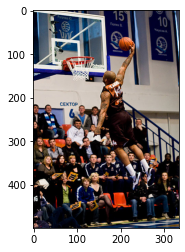

In [72]:
random_test_image_path = dataset_images_path + '/' + random.choice(test_img_name_list)
test_feature = test_extract_features(random_test_image_path, xception)
image = Image.open(random_test_image_path)
caption = test_generate_caption(model_LSTM, tokenizer, test_feature, max_length)
print(caption)
plt.imshow(image)

In [73]:
from tensorflow.keras.layers import SimpleRNN

In [74]:
def define_model_RNN(total_words, max_length):
    input_1 = Input(shape=(2048,))
    fe1 = Dropout(0.25)(input_1)
    fe2 = Dense(256, activation='relu')(fe1)
    
    input_2 = Input(shape=(max_length,))
    se1 = Embedding(total_words, 1024, mask_zero=True)(input_2)
    se2 = Dropout(0.25)(se1)
    se3 = SimpleRNN(256, activation='tanh')(se2)
    
    decoder1 = concatenate([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(total_words, activation='softmax')(decoder2)
    
    model = Model(inputs=[input_1, input_2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    model.summary()
    
    return model

In [75]:
model_RNN = define_model_RNN(vocab_size, max_length)

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 35)]         0           []                               
                                                                                                  
 input_16 (InputLayer)          [(None, 2048)]       0           []                               
                                                                                                  
 embedding_5 (Embedding)        (None, 35, 1024)     7494656     ['input_17[0][0]']               
                                                                                                  
 dropout_10 (Dropout)           (None, 2048)         0           ['input_16[0][0]']               
                                                                                            

In [76]:
batch_size = 60
steps = len(train_img_list) // batch_size
for i in tqdm(range(epochs)):
#     print('Big Epoch ' + str(i+1))
    generator = data_generator(train_descriptions, train_features, tokenizer, max_length, vocab_size, batch_size)
    model_RNN.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

  0%|          | 0/15 [00:00<?, ?it/s]

100/100 [==============================] - 95s 950ms/step - loss: 1.1532


In [78]:
import nltk

original caption:  ['dog walks down the dirt road as person follows', 'tan dog walks ahead of man in dry area', 'white dog is going for walk through the desert with its owner', 'yellow dog is walking along mountain trail', 'dog in desert area with distant man in background']

LSTM generated caption:  start brown dog running through the snow end

RNN generated caption:  start brown and white bird standing on frozen lake and snow end

BLEU score for LSTM predicted Caption:  0.11633369384516798
BLEU score for RNN predicted Caption:  0


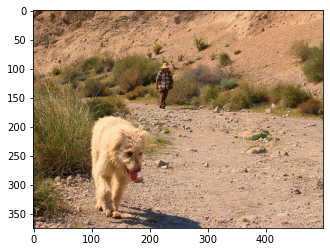

In [98]:
r=random.choice(test_img_name_list)
random_test_image_path = dataset_images_path + '/' + r
test_feature = test_extract_features(random_test_image_path, xception)
image = Image.open(random_test_image_path)
captionL = test_generate_caption(model_LSTM, tokenizer, test_feature, max_length)
captionR = test_generate_caption(model_RNN, tokenizer, test_feature, max_length)


reference=cleaned_descriptions[r]
print('original caption: ', reference)
print('\nLSTM generated caption: ',captionL)
print('\nRNN generated caption: ',captionR)

hypothesisL=list(captionL.split())
hypothesisR=list(captionR.split())

BLEUL=0
BLEUR=0

for i in reference:
    a=nltk.translate.bleu_score.sentence_bleu([i.split()],hypothesisL,weights = (0.5, 0.5))
    b=nltk.translate.bleu_score.sentence_bleu([i],hypothesisR[1:-1],weights = (0.5, 0.5))
    if a>BLEUL:
        BLEUL=a
    if b>BLEUR:
        BLEUR=b


print('\nBLEU score for LSTM predicted Caption: ',BLEUL)
print('BLEU score for RNN predicted Caption: ',BLEUR)
plt.imshow(image)


original caption:  ['black dog in the middle of running or leaping', 'black dog is running quickly along the ground', 'rottweiler running', 'the brown and black dog sprints across the snow', 'there is black and tan dog bounding through the air']

LSTM generated caption:  start brown and white dog hauling in floating toy end

RNN generated caption:  start brown dog is running through the water end

BLEU score for LSTM predicted Caption:  0.18257418583505533
BLEU score for RNN predicted Caption:  0


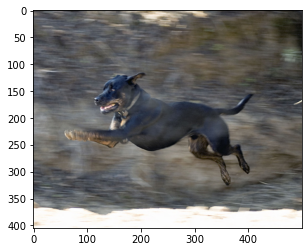

In [97]:
r=random.choice(test_img_name_list)
random_test_image_path = dataset_images_path + '/' + r
test_feature = test_extract_features(random_test_image_path, xception)
image = Image.open(random_test_image_path)
captionL = test_generate_caption(model_LSTM, tokenizer, test_feature, max_length)
captionR = test_generate_caption(model_RNN, tokenizer, test_feature, max_length)


reference=cleaned_descriptions[r]
print('original caption: ', reference)
print('\nLSTM generated caption: ',captionL)
print('\nRNN generated caption: ',captionR)

hypothesisL=list(captionL.split())
hypothesisR=list(captionR.split())

BLEUL=0
BLEUR=0

for i in reference:
    a=nltk.translate.bleu_score.sentence_bleu([i.split()],hypothesisL,weights = (0.5, 0.5))
    b=nltk.translate.bleu_score.sentence_bleu([i],hypothesisR,weights = (0.5, 0.5))
    if a>BLEUL:
        BLEUL=a
    if b>BLEUR:
        BLEUR=b


print('\nBLEU score for LSTM predicted Caption: ',BLEUL)
print('BLEU score for RNN predicted Caption: ',BLEUR)
plt.imshow(image)


original caption:  ['man crashes into the water with his parachute', 'parasailer splashes along the surface of lake', 'person hanging from parachute makes splash as their body hits the water', 'person in parachute sliding across the water', 'the parasailer is skipping across the water']

LSTM generated caption:  start little girl is standing through the water end

RNN generated caption:  start young boy runs through the streets end

BLEU score for LSTM predicted Caption:  0.20412414523193154
BLEU score for RNN predicted Caption:  0


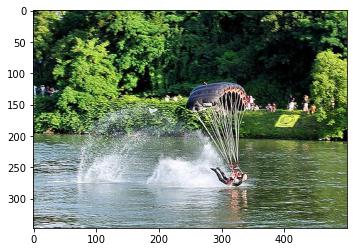

In [93]:
r=random.choice(test_img_name_list)
random_test_image_path = dataset_images_path + '/' + r
test_feature = test_extract_features(random_test_image_path, xception)
image = Image.open(random_test_image_path)
captionL = test_generate_caption(model_LSTM, tokenizer, test_feature, max_length)
captionR = test_generate_caption(model_RNN, tokenizer, test_feature, max_length)


reference=cleaned_descriptions[r]
print('original caption: ', reference)
print('\nLSTM generated caption: ',captionL)
print('\nRNN generated caption: ',captionR)

hypothesisL=list(captionL.split())
hypothesisR=list(captionR.split())

BLEUL=0
BLEUR=0

for i in reference:
    a=nltk.translate.bleu_score.sentence_bleu([i.split()],hypothesisL,weights = (0.5, 0.5))
    b=nltk.translate.bleu_score.sentence_bleu([i],hypothesisR,weights = (0.5, 0.5))
    if a>BLEUL:
        BLEUL=a
    if b>BLEUR:
        BLEUR=b


print('\nBLEU score for LSTM predicted Caption: ',BLEUL)
print('BLEU score for RNN predicted Caption: ',BLEUR)
plt.imshow(image)


original caption:  ['dog standing in the shallow part of the ocean while the waves splash around', 'dog standing in the water', 'wrinkled dog wading in shallow water', 'the large brown dog is walking through water in the ocean', 'the large brown dog stands in the choppy water']

LSTM generated caption:  start brown dog running through the sand end

RNN generated caption:  start brown dog and brown dog is running through the water end

BLEU score for LSTM predicted Caption:  0.20425834259995942
BLEU score for RNN predicted Caption:  0


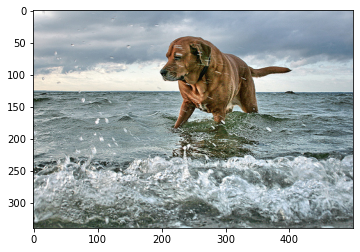

In [107]:
r=random.choice(test_img_name_list)
random_test_image_path = dataset_images_path + '/' + r
test_feature = test_extract_features(random_test_image_path, xception)
image = Image.open(random_test_image_path)
captionL = test_generate_caption(model_LSTM, tokenizer, test_feature, max_length)
captionR = test_generate_caption(model_RNN, tokenizer, test_feature, max_length)


reference=cleaned_descriptions[r]
print('original caption: ', reference)
print('\nLSTM generated caption: ',captionL)
print('\nRNN generated caption: ',captionR)

hypothesisL=list(captionL.split())
hypothesisR=list(captionR.split())

BLEUL=0
BLEUR=0

for i in reference:
    a=nltk.translate.bleu_score.sentence_bleu([i.split()],hypothesisL,weights = (0.5, 0.5))
    b=nltk.translate.bleu_score.sentence_bleu([i],hypothesisR,weights = (0.5, 0.5))
    if a>BLEUL:
        BLEUL=a
    if b>BLEUR:
        BLEUR=b


print('\nBLEU score for LSTM predicted Caption: ',BLEUL)
print('BLEU score for RNN predicted Caption: ',BLEUR)
plt.imshow(image)
